In [6]:
import pandas as pd
import pickle

path2 = "/Users/amaros/Desktop/mgss2/log_norm.pkl"

with open(path2, 'rb') as file:
        metabolomics = pickle.load(file)       

mgcsts_samples_df = pd.read_csv("../Data/mgCSTs.samples.df.csv")

minclustersize = 10
deepsplit = 4

df = mgcsts_samples_df[(mgcsts_samples_df['minClusterSize'] == minclustersize) & (mgcsts_samples_df['deepSplit'] == deepsplit)].reset_index(drop = True)

In [7]:
GroupA = [1,2,3,4]
GroupB = [5,6,7,8]

def data_pca(m1,m2):
    df1 = df[df['mgCST'].isin(range(m1[0],m1[1]+1))]
    df1.loc[:,'label'] = "GroupA"
    df2 = df[df['mgCST'].isin(range(m2[0],m2[1]+1))]
    df2.loc[:,'label'] = "GroupB"
    df3 = pd.concat([df1,df2], axis = 0)
    data1 = pd.merge(df3, metabolomics, on = "sampleID", how = "inner")
    return data1

data1 = data_pca(GroupA, GroupB)

/var/folders/h5/ld8fm2tx5hx6b_hqkmxxbx_00000gp/T/ipykernel_37850/148187111.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:,'label'] = "GroupA"
/var/folders/h5/ld8fm2tx5hx6b_hqkmxxbx_00000gp/T/ipykernel_37850/148187111.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:,'label'] = "GroupB"


In [9]:
data1 = data1.drop(['dtc','domTaxa','relabund','minClusterSize','deepSplit', 'sampleID', 'mgCST', 'label'], axis = 1)
data1.head(2)

,lactate:phosphate,leucine:phosphate,glutamate:phosphate,isoleucine:phosphate,choline:phosphate,phenylalanine:phosphate,proline:phosphate,creatine:phosphate,alanine:phosphate,arginine:phosphate,...,paroxetine:ibuprofen acyl glucuronide,gabapentin:ibuprofen acyl glucuronide,gabapentin:paroxetine,glucuronide of C12H22O4 (2)*:sulforaphane-N-acetyl-cysteine,X-24736:sulforaphane-N-acetyl-cysteine,X-24736:glucuronide of C12H22O4 (2)*,venlafaxine:O-desmethylvenlafaxine,N-desmethyl tramadol:tramadol,O-desmethyltramadol:tramadol,O-desmethyltramadol:N-desmethyl tramadol
0,-1.045851,-1.801774,-1.944900,-1.978953,-1.19183,-1.928208,-1.697852,-1.780703,-1.921703,-2.383224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.418946,2.084061,2.447152,1.869037,0.87723,1.784691,1.557010,2.141756,1.295587,2.100969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=6)
principal_components = pca.fit_transform(data1)
explained_variance = pca.explained_variance_ratio_
components_compo = pca.components_

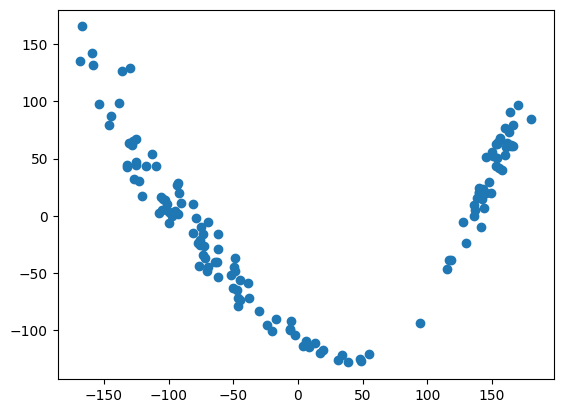

In [13]:
import matplotlib.pyplot as plt

pca_df = pd.DataFrame(data = principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

plt.scatter(pca_df['PC1'], pca_df['PC2'])

In [16]:
cols = data1.columns

Index(['lactate:phosphate', 'leucine:phosphate', 'glutamate:phosphate',
       'isoleucine:phosphate', 'choline:phosphate', 'phenylalanine:phosphate',
       'proline:phosphate', 'creatine:phosphate', 'alanine:phosphate',
       'arginine:phosphate',
       ...
       'paroxetine:ibuprofen acyl glucuronide',
       'gabapentin:ibuprofen acyl glucuronide', 'gabapentin:paroxetine',
       'glucuronide of C12H22O4 (2)*:sulforaphane-N-acetyl-cysteine',
       'X-24736:sulforaphane-N-acetyl-cysteine',
       'X-24736:glucuronide of C12H22O4 (2)*',
       'venlafaxine:O-desmethylvenlafaxine', 'N-desmethyl tramadol:tramadol',
       'O-desmethyltramadol:tramadol',
       'O-desmethyltramadol:N-desmethyl tramadol'],
      dtype='object', length=250144)

In [22]:
abs(pca.components_[0])

array([0.00990596, 0.01033339, 0.01115849, ..., 0.        , 0.        ,
       0.        ])

In [17]:
import numpy as np
def top_features(pc):
   
    top_features = []
    for i in range(len(cols)):
        index = cols[np.where(sorted(abs(pca.components_[pc]),reverse=True)[i] == abs(pca.components_[pc]))].values[0]
        top_features.append(index)

    return top_features

# top_features(0)
top_features(0)[:5]

KeyboardInterrupt: 

In [ ]:
plt.bar(top_features(0)[:5], pca.components_[0][:5])

In [24]:
a = [0,1,2,3,4,5,6,7,8,9]
b = [12,5,6,9,14,65,20,32,74,56]

sorted(b, reverse = True)

[74, 65, 56, 32, 20, 14, 12, 9, 6, 5]

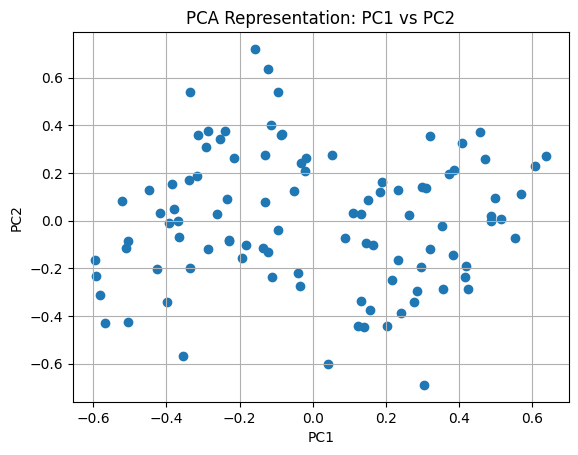

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Example data
data = np.random.rand(100, 3)  # Replace this with your actual data

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

# Create a scatter plot of PC1 vs PC2
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Representation: PC1 vs PC2')
plt.grid(True)
plt.show()


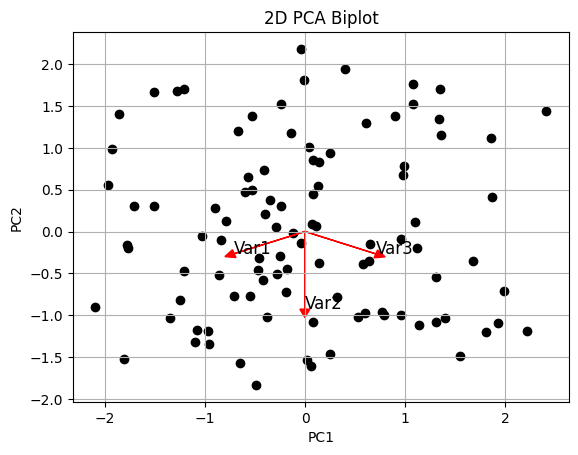

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Example data (replace with your data)
data = np.random.rand(100, 3)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

# Create a scatter plot of PC1 vs PC2
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='black', marker='o')

# Add labels for the original variables as vectors (biplot)
for i, var_name in enumerate(['Var1', 'Var2', 'Var3']):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], head_width=0.1, head_length=0.1, fc='r', ec='r')
    plt.text(pca.components_[0, i], pca.components_[1, i], var_name, fontsize=12)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D PCA Biplot')
plt.grid(True)
plt.show()
